# ¿Aceptarías 1 palo USD a cambio de spawnear en un lugar aleatorio de la Tierra?

Primero, generamos coordenadas aleatorias de latitud y longitud teniendo en cuenta lo siguiente:

- Para la longitud, nos generamos puntos aleatorios uniformemente distribuidos entre los -180 y 180 grados.
- Para la latitud, no podemos simplemente generar puntos aleatorios uniformemente distribuidos entre los -90 y 90 grados. Si hiciéramos eso, estaríamos sobrerrepresentando las regiones polares porque cada grado de latitud en el ecuador cubre una superficie mucho mayor que cada grado en los polos. En términos de superficie terrestre, cada franja de latitud cubre un área proporcional a $cos(\phi)$. Por lo tanto, una distribución verdaderamente uniforme en la superficie terrestre debería generar $\phi$ según:

$$\phi = arcsin(rand(-1,1))$$


In [3]:
#Importamos librarías

import geopandas as gpd
import pandas as pd
import random
import numpy as np
from shapely.geometry import Point

def coordenadas(n):
    data = {
        "latitud": np.degrees(np.arcsin([random.uniform(-1, 1) for _ in range(n)])), 
        "longitud": [random.uniform(-180, 180) for _ in range(n)]
    }

    df = pd.DataFrame(data)
    return df

num_coordenadas = 100

df_coordenadas = coordenadas(num_coordenadas)

import folium

mapa = folium.Map(location=[df_coordenadas['latitud'].mean(), df_coordenadas['longitud'].mean()], zoom_start=12)

for _, row in df_coordenadas.iterrows():
    if pd.notna(row['latitud']) and pd.notna(row['longitud']):
        folium.Marker(location=[row['latitud'], row['longitud']], popup=f"{row['latitud']}, {row['longitud']}").add_to(mapa)

mapa.save('mapa_100.html')

Ahora, considerando que cerca del 70% de la superficie terrestre está cubierta por agua, vamos a incluir en el juego sólo la parte que no lo esté. 

In [6]:
#Importamos librarías

import geopandas as gpd
from shapely.geometry import Point

land = gpd.read_file("C:/Users/Usuario/OneDrive/Documentos/Tiktok/ne_50m_land.shp") 

def coordenadas_tierra(n):
    data = {"latitud": [], "longitud": []}

    while len(data["latitud"]) < n:
        lat = np.degrees(np.arcsin(random.uniform(-1, 1)))  
        lon = random.uniform(-180, 180)
        point = Point(lon, lat)  

        if land.contains(point).any():
            data["latitud"].append(lat)
            data["longitud"].append(lon)

    return pd.DataFrame(data)

num_coordenadas = 100
df_coordenadas_tierra = coordenadas_tierra(num_coordenadas)
print(df_coordenadas_tierra)


      latitud    longitud
0   24.571225   -5.241438
1  -26.639618  142.900115
2  -23.902363  -57.823922
3    8.987975   38.829552
4   -8.639054  -71.589191
..        ...         ...
95  66.660545  176.824707
96  25.063322   81.009526
97  62.847730   10.910535
98 -49.402971   69.407390
99  30.471961   -2.235605

[100 rows x 2 columns]


Luego, graficamos nuestras coordenadas en el mapa y lo guardamos:

In [15]:
mapa = folium.Map(location=[df_coordenadas['latitud'].mean(), df_coordenadas['longitud'].mean()], zoom_start=12)

for _, row in df_coordenadas.iterrows():
    if pd.notna(row['latitud']) and pd.notna(row['longitud']):
        folium.Marker(location=[row['latitud'], row['longitud']], popup=f"{row['latitud']}, {row['longitud']}").add_to(mapa)

mapa.save('mapa_100_tierra.html')


In [12]:
import requests

def sobrevive(lat, lon, radius=30000):
    """Verifica si hay asentamientos humanos en un radio de X metros usando OpenStreetMap"""
    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json];
    (
      node(around:{radius},{lat},{lon})["place"];
      way(around:{radius},{lat},{lon})["building"];
      relation(around:{radius},{lat},{lon})["place"];
    );
    out center;
    """
    response = requests.get(overpass_url, params={"data": query})
    data = response.json()
    return len(data.get("elements", [])) > 0

lat = df_coordenadas["latitud"]
lon = df_coordenadas["longitud"]

df_coordenadas["habitadas"] = df_coordenadas.apply(lambda row: sobrevive(row["latitud"], row["longitud"]), axis=1)



In [13]:

print(df_coordenadas)

      latitud    longitud  habitadas
0   75.829694 -113.821418       True
1   46.653558  -91.286719       True
2   42.705280   57.407420      False
3  -25.118014  137.580280      False
4   13.874530  -84.685630       True
..        ...         ...        ...
95  54.245141  123.423678       True
96  58.746500 -114.972356       True
97 -17.560063  125.455228       True
98 -72.152860  105.513080      False
99  28.714606   16.786039      False

[100 rows x 3 columns]


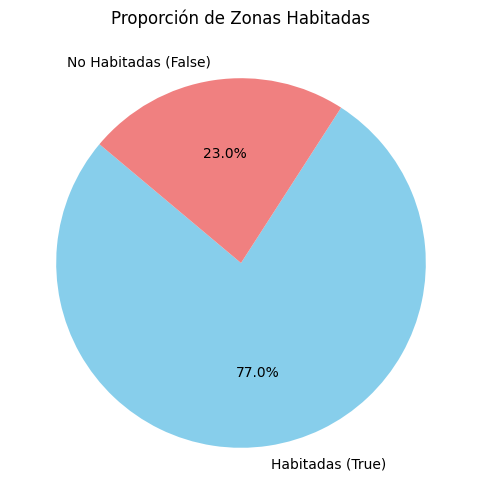

Proporción de True: 77.00%


In [ ]:
import matplotlib.pyplot as plt

proporcion_true = df_coordenadas["habitadas"].mean()

# Grafico
labels = ["Sí", "No"]
sizes = [proporcion_true, 1 - proporcion_true]
colors = ["skyblue", "lightcoral"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
plt.title("¿Hay asentamientos humanos en un radio de 30km?")
plt.show()

print(f"Proporción de True: {proporcion_true:.2%}")
